# Group Details
## Group Name:
### Student 1: Johan van Dongen
### Student 2:
### Student 3:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import os

In [2]:
def load_trajectory(filename, task):

    traj = np.load(filename)
    if task == 'task_1' or task == 'task_2':
        trajectory = traj['trajectory']
        energy = traj['energy']
        return trajectory, energy
    if task == 'task_3':
        trajectory = traj['trajectory']
        framework = traj['framework']
        energy = traj['energy']
        return trajectory, framework, energy

# Data Exploration

Below, you can find an example of how to load a trajectory. ```trajectory``` contains the particle position, velocity and charge data. ```energy``` contains the energy of the system at various timesteps. The shape of the arrays is as follows:

```trajectory```: ```(time, n_bodies, [x, y, v_x, v_y, q])```

```energy```: ```(time, 1)```

In [3]:
trajectory, energy = load_trajectory('data/task1_2/test/trajectory_900.npz', 'task_1')
print(f'Trajectory shape: {trajectory.shape}, Energy shape: {energy.shape}')
# 40 steps - 4 trajectories - 5 inputs (x, y, vx, vy, q)

Trajectory shape: (40, 3, 5), Energy shape: (40, 1)


The following code provides an example of how to visualize a trajectory. Feel free to modify this code, or write your own function. When evaluating your model in task 2 and 3, keep in mind that you are only allowed to use the data at t=0 (the black dots in the visualization).

In [4]:
print(trajectory[0])
traj = [step.flatten() for step in trajectory]
print(traj[0])
# traj = torch.tensor(traj)

[[ 9.15666243 14.44253387 -0.33940448  0.29948979 -1.        ]
 [10.65836182  9.49862691 -0.13746563 -0.50589561 -1.        ]
 [ 6.79699051 14.52094816  0.19959454  0.42062426 -1.        ]]
[ 9.15666243 14.44253387 -0.33940448  0.29948979 -1.         10.65836182
  9.49862691 -0.13746563 -0.50589561 -1.          6.79699051 14.52094816
  0.19959454  0.42062426 -1.        ]


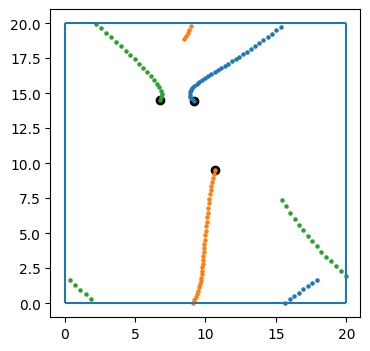

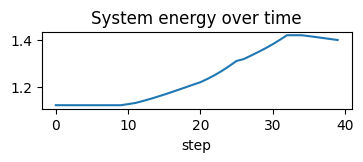

In [5]:
x = trajectory[...,0]
y = trajectory[...,1]

plt.figure(figsize=(4,4))
plt.vlines([0,20],0,20)
plt.hlines([0,20],0,20)

plt.scatter(x[0], y[0], c='black')

for i in range(x.shape[1]):
    plt.scatter(x[:,i], y[:,i], s=5)

plt.xlim(-1,21)
plt.ylim(-1,21)

plt.show()
plt.figure(figsize=(4,1))
plt.plot(energy)
plt.xlabel('step')
plt.title('System energy over time')
plt.show();

# Task 1

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create Dataset

In [8]:
class TrajectoryDataset(Dataset):
    def __init__(self, train=True):
        type = "train" if train else "test"
        trajectories = []
        energies = []
        files = os.listdir('data/task1_2/' + type)
        for file in tqdm(files):
            if ".npz" in file:
                trajectory, energy = load_trajectory('data/task1_2/' + type + "/" + file, 'task_1')
                trajectories.append(trajectory)
                energies.append(energy)
        # self.x = torch.tensor([step.flatten() for trajectory in trajectories for step in trajectory ], dtype=torch.float32)
        self.x = [[particle.flatten() for particle in step] for trajectory in trajectories for step in trajectory ]
        self.y = torch.tensor(np.array(energies).flatten(), dtype=torch.float32)
        self.n_samples = len(self.y)

    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.n_samples
train_task1 = TrajectoryDataset()
test_task1 = TrajectoryDataset(train=False)

100%|██████████| 200/200 [00:01<00:00, 171.37it/s]


We have either 3, 4 or 5 particles in a trajectory. Each trajectory is thus of variable length of 15, 20 or 25 (times 5, cuz each particle has x,y, vx, vy, q)

To deal with this variable length we need a collate batch function that will pad the sequences with zeros (so all sequences will be of length 25 I guess?)

In [9]:
def collate_batch(batch):
    label_list, text_list = [], []
    for (_text, _label) in batch:
        label_list.append(_label)    
        processed_text = torch.tensor(_text, dtype=torch.float32)
        text_list.append(processed_text)

        
    # convert label_lists to torch.tensor that is compatible with pytorch
    label_batch = torch.tensor(label_list, dtype=torch.float32)
    
    # add zeros to ensure that all sequences have same length
    padded_text_batch = pad_sequence(sequences = text_list, batch_first=True, padding_value=0.0)
    
    return label_batch, padded_text_batch

In [11]:
train_dataloader = DataLoader(dataset=train_task1, batch_size=1, collate_fn=collate_batch)
energies = []
for idx, (y_true, trajectory_batch) in enumerate(train_dataloader):
    energies.append(y_true)

36000


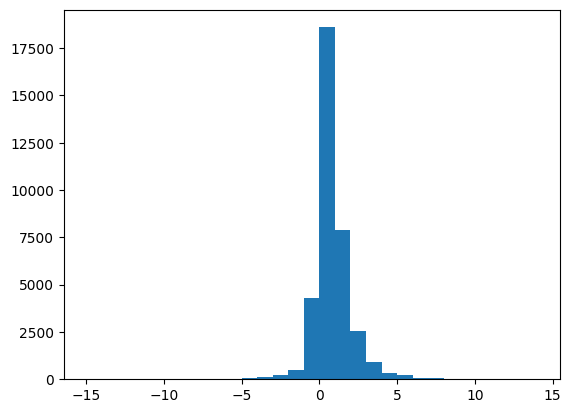

In [21]:
print(len(energies))
plt.hist([x.item() for x in energies], bins=[x for x in range(-15,15)])
plt.show()

# Model - Energy Predictor

In [17]:
class EnergyPredictor(nn.Module):
    def __init__(self, input_size=5, hidden_dim=32):
        super(EnergyPredictor, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_dim, 2, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.parameters())

    def forward(self, steps):
        out, (hidden, _) = self.rnn(steps)
        out = self.fc(out)
        last_timestep = out[:,-1] # Only keep the last output (that output is based on all the particles in the trajectory combined, instead of a subset thereof)
        return last_timestep
model = EnergyPredictor().to(device)

# Training

In [18]:
import time

class Trainer():
    def __init__(self, epochs, batch_size):
        self.epochs = epochs
        self.batch_size = batch_size

    def train(self, dataloader):
        model.train()
        losses = []
        for (y_true, trajectory_batch) in tqdm(dataloader):
            
            model.optimizer.zero_grad()
            
            y_pred = model(trajectory_batch)
            
            loss = model.criterion(y_pred, y_true)
            losses.append(loss.item())
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            model.optimizer.step()
                
        return np.array(losses).mean()

    def evaluate(self, dataloader):
        model.eval()
        losses = []
        with torch.no_grad():
            for idx, (y_true, trajectory_batch) in enumerate(dataloader):
                y_pred = model(trajectory_batch)
                loss = model.criterion(y_pred, y_true)
                losses.append(loss.item())

        return np.array(losses).mean()
    
    def run_trainer(self):
        train_loss, val_loss = [], []
        for epoch in range(1, self.epochs + 1):
            epoch_start_time = time.time()
            train_dataloader = DataLoader(dataset=train_task1, batch_size=self.batch_size, collate_fn=collate_batch)
            test_dataloader = DataLoader(dataset=test_task1, batch_size=self.batch_size, collate_fn=collate_batch)
            train_loss.append(self.train(train_dataloader))
            val_loss.append(self.evaluate(test_dataloader))
            
            print('-' * 59)
            print('| end of epoch {:3d} | time: {:5.2f}s | ' 'train loss {:8.3f} valid loss {:8.3f}'.format(epoch, time.time() - epoch_start_time, train_loss[-1], val_loss[-1]))
            print('-' * 59)

In [19]:
# hyperparameters
EPOCHS = 10 # epoch
BATCH_SIZE = 128 # batch size for training/validation

trainer = Trainer(EPOCHS, BATCH_SIZE)
trainer.run_trainer()

  0%|          | 0/282 [00:00<?, ?it/s]c:\Users\20203755\envs\dataScience\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 97%|█████████▋| 273/282 [00:03<00:00, 80.70it/s]c:\Users\20203755\envs\dataScience\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 282/282 [00:03<00:00, 81.11it/s]


-----------------------------------------------------------
| end of epoch   1 | time:  3.69s | train loss    3.639 valid loss    1.448
-----------------------------------------------------------


100%|██████████| 282/282 [00:03<00:00, 83.56it/s]


-----------------------------------------------------------
| end of epoch   2 | time:  3.59s | train loss    3.604 valid loss    1.430
-----------------------------------------------------------


100%|██████████| 282/282 [00:03<00:00, 81.14it/s]


-----------------------------------------------------------
| end of epoch   3 | time:  3.68s | train loss    3.604 valid loss    1.432
-----------------------------------------------------------


100%|██████████| 282/282 [00:03<00:00, 82.42it/s]


-----------------------------------------------------------
| end of epoch   4 | time:  3.60s | train loss    3.602 valid loss    1.431
-----------------------------------------------------------


100%|██████████| 282/282 [00:03<00:00, 80.15it/s]


-----------------------------------------------------------
| end of epoch   5 | time:  3.74s | train loss    3.599 valid loss    1.431
-----------------------------------------------------------


100%|██████████| 282/282 [00:03<00:00, 81.35it/s]


-----------------------------------------------------------
| end of epoch   6 | time:  3.67s | train loss    3.598 valid loss    1.431
-----------------------------------------------------------


100%|██████████| 282/282 [00:03<00:00, 79.31it/s]


-----------------------------------------------------------
| end of epoch   7 | time:  3.77s | train loss    3.598 valid loss    1.431
-----------------------------------------------------------


100%|██████████| 282/282 [00:03<00:00, 73.55it/s]


-----------------------------------------------------------
| end of epoch   8 | time:  4.05s | train loss    3.597 valid loss    1.430
-----------------------------------------------------------


100%|██████████| 282/282 [00:03<00:00, 78.46it/s]


-----------------------------------------------------------
| end of epoch   9 | time:  3.82s | train loss    3.597 valid loss    1.429
-----------------------------------------------------------


100%|██████████| 282/282 [00:04<00:00, 63.46it/s]


-----------------------------------------------------------
| end of epoch  10 | time:  4.75s | train loss    3.596 valid loss    1.428
-----------------------------------------------------------


# Visualize

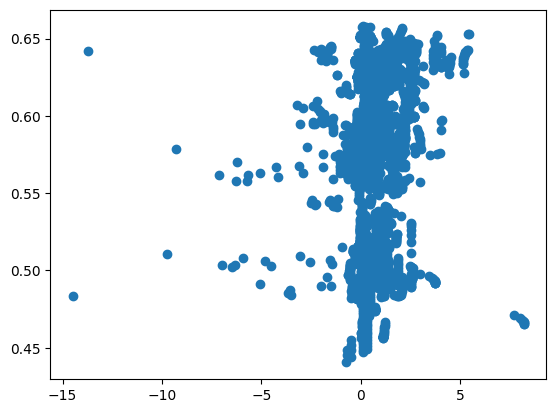

In [20]:
# ...
test_dataloader = DataLoader(dataset=test_task1, batch_size=1, collate_fn=collate_batch)
predict = []
true = []
def evaluate(dataloader):
    model.eval()
    losses = []
    with torch.no_grad():
        for idx, (y_true, trajectory_batch) in enumerate(dataloader):
            y_pred = model(trajectory_batch)
            true.append(y_true)
            predict.append(y_pred)
            # print(y_pred, y_true)
evaluate(test_dataloader)
plt.scatter(true, predict)
plt.show()

# Task 2

Implement task 2 below. Feel free to add extra code cells for different components of your implementation.

# Create Dataset

In [94]:
class TrajectoryDataset(Dataset):
    def __init__(self, train=True):
        type = "train" if train else "test"
        trajectories = []
        files = list(filter(lambda file: ".npz" in file ,os.listdir('data/task1_2/' + type)))
        for file in tqdm(files):
            trajectory, energy = load_trajectory('data/task1_2/' + type + "/" + file, 'task_1')
            num_particles = trajectory.shape[1]
            for i in range(num_particles):
                trajectories.append(trajectory[:,i])
        self.x = torch.tensor(trajectories, dtype=torch.float32)
        print(self.x.shape)
        self.y = self.x
        self.n_samples = len(trajectories)

    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.n_samples
train_task1 = TrajectoryDataset()
test_task1 = TrajectoryDataset(train=False)

100%|██████████| 900/900 [00:00<00:00, 1370.26it/s]


torch.Size([3587, 40, 5])


100%|██████████| 100/100 [00:01<00:00, 58.20it/s]

torch.Size([390, 40, 5])


In [95]:
train_dataloader = DataLoader(dataset=train_task1, batch_size=1)
test_dataloader = DataLoader(dataset=test_task1, batch_size=1)
for idx, (y_true, trajectory_batch) in enumerate(train_dataloader):
    print(idx, y_true, trajectory_batch)
    break

0 tensor([[[ 9.5955e+00,  7.5320e+00,  5.1612e-01, -6.9281e-02, -1.0000e+00],
         [ 9.8588e+00,  7.4987e+00,  5.3647e-01, -6.3824e-02, -1.0000e+00],
         [ 1.0132e+01,  7.4680e+00,  5.5510e-01, -5.8939e-02, -1.0000e+00],
         [ 1.0414e+01,  7.4397e+00,  5.7192e-01, -5.4423e-02, -1.0000e+00],
         [ 1.0703e+01,  7.4136e+00,  5.8697e-01, -5.0101e-02, -1.0000e+00],
         [ 1.1000e+01,  7.3896e+00,  6.0038e-01, -4.5854e-02, -1.0000e+00],
         [ 1.1304e+01,  7.3677e+00,  6.1234e-01, -4.1624e-02, -1.0000e+00],
         [ 1.1612e+01,  7.3480e+00,  6.2306e-01, -3.7415e-02, -1.0000e+00],
         [ 1.1926e+01,  7.3303e+00,  6.3276e-01, -3.3287e-02, -1.0000e+00],
         [ 1.2245e+01,  7.3147e+00,  6.4163e-01, -2.9347e-02, -1.0000e+00],
         [ 1.2568e+01,  7.3009e+00,  6.4984e-01, -2.5737e-02, -1.0000e+00],
         [ 1.2895e+01,  7.2888e+00,  6.5756e-01, -2.2624e-02, -1.0000e+00],
         [ 1.3225e+01,  7.2782e+00,  6.6489e-01, -2.0204e-02, -1.0000e+00],
         [

# Model - Trajectory Predictor

In [83]:
class TrajectoryPredictor(nn.Module):
    def __init__(self, input_size=5, hidden_dim=32):
        super(TrajectoryPredictor, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_dim, 2, batch_first=True)
        self.fc = nn.Linear(hidden_dim, input_size)
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.parameters())

    def forward(self, steps, hidden_state=None):
        out, hidden_state = self.rnn(steps, hidden_state)
        out = self.fc(out)
        # last_timestep = out[:,-1] # Only keep the last output (that output is based on all the particles in the trajectory combined, instead of a subset thereof)
        return out, hidden_state
model = TrajectoryPredictor().to(device)

# Trainer

In [122]:
import time

class Trainer():
    def __init__(self, epochs, batch_size):
        self.epochs = epochs
        self.batch_size = batch_size

    def train(self, dataloader):
        pass

    def evaluate(self, dataloader):
        pass
    
    def run_trainer(self):
        seq_len = 40
        teacher_forcing_ratio = 0.5
        train_dataloader = DataLoader(dataset=train_task1, batch_size=1)
        input_data = train_dataloader
        # test_dataloader = DataLoader(dataset=test_task1, batch_size=self.batch_size, collate_fn=collate_batch)
        for epoch in range(self.epochs):
            model.train()
            model.optimizer.zero_grad()
            
            hidden_state = None
            loss = 0
            losses = []
            
            for idx, (y_true, trajectory_batch) in tqdm(enumerate(train_dataloader)):
                # model.train()
                # model.optimizer.zero_grad()
                # hidden_state = None
                # loss = 0
                for t in range(seq_len-1, seq_len):  # seq_len is the number of time steps
                    # print(trajectory_batch.shape)
                    input_t = trajectory_batch.squeeze()[:t]
                    # print("input", input_t.shape)
                    # print("input", len(input_t))
                    target_t = trajectory_batch.squeeze()[1:t + 1]
                    
                    # if t == 1 or torch.rand(1).item() < teacher_forcing_ratio:
                    #     input_t = trajectory_batch.squeeze()[:t]
                    # else:
                    #     input_t = output_t.detach()
                    
                    output_t, hidden_state = model(input_t.squeeze(1), hidden_state)
                    # print(output_t.shape, target_t.shape)
                    loss += model.criterion(output_t.squeeze(1), target_t.squeeze(1))
                # print(idx, loss)
                if (idx%1 == 0):
                    losses.append(loss.item())
                    loss.backward()
                    model.optimizer.step()
                    hidden_state = None
                    loss = 0
                # if (idx > 10):
                #     break
            # loss.backward()
            # model.optimizer.step()
            
            print(f'Epoch {epoch+1}/{self.epochs}, Loss: {np.array(losses).mean()}')

In [123]:
trainer = Trainer(10, 1)
trainer.run_trainer()

3587it [00:13, 258.44it/s]


Epoch 1/10, Loss: 3.601302169851184


3587it [00:14, 245.37it/s]


Epoch 2/10, Loss: 3.7589169499483286


3587it [00:15, 232.71it/s]


Epoch 3/10, Loss: 3.160000587917152


3587it [00:16, 221.85it/s]


Epoch 4/10, Loss: 3.3730516197507283


3587it [00:16, 218.55it/s]


Epoch 5/10, Loss: 3.1439198056136726


3587it [00:16, 215.10it/s]


Epoch 6/10, Loss: 2.8287077847549367


3587it [00:17, 208.13it/s]


Epoch 7/10, Loss: 3.3889891599708193


3587it [00:17, 204.80it/s]


Epoch 8/10, Loss: 3.6827893208952247


3587it [00:17, 202.07it/s]


Epoch 9/10, Loss: 3.6062625222861486


3587it [00:18, 197.70it/s]

Epoch 10/10, Loss: 3.4096654041965992


In [124]:
def run_trainer():
    seq_len = 40
    # teacher_forcing_ratio = 0.5
    test_dataloader = DataLoader(dataset=test_task1, batch_size=1)
    input_data = train_dataloader
    model.eval()
    with torch.no_grad():
        hidden_state = None
        loss = 0
        for idx, (y_true, trajectory_batch) in tqdm(enumerate(test_dataloader)):
            for t in range(1, seq_len):  # seq_len is the number of time steps
                input_t = trajectory_batch.squeeze()[:t]
                target_t = trajectory_batch.squeeze()[1:t + 1]
                output_t, hidden_state = model(input_t.squeeze(1), hidden_state)
                loss = model.criterion(output_t.squeeze(1), target_t.squeeze(1))
            print(f'Loss: {loss.item()}')
            print(f"pred: {output_t[-1][:2]}, y_true: {trajectory_batch.squeeze()[-1][:2]}")
            if (idx>10):
                break
run_trainer()
            

6it [00:00, 28.32it/s]

Loss: 3.4245493412017822
pred: tensor([15.1989,  3.7665]), y_true: tensor([17.9282,  1.6364])
Loss: 3.3717751502990723
pred: tensor([ 8.4964, 14.6131]), y_true: tensor([ 8.4593, 18.8855])
Loss: 6.747257709503174
pred: tensor([14.5227,  8.1361]), y_true: tensor([15.4104,  7.3697])
Loss: 3.3061325550079346
pred: tensor([14.5087, 14.9619]), y_true: tensor([13.7451,  0.3136])
Loss: 2.5463972091674805
pred: tensor([ 1.7068, 13.3004]), y_true: tensor([ 1.3961, 14.8239])
Loss: 3.9987595081329346
pred: tensor([14.4808, 14.9208]), y_true: tensor([19.6821, 13.8390])
Loss: 3.5786144733428955
pred: tensor([14.5225,  8.1370]), y_true: tensor([13.3681,  6.5914])
Loss: 5.252159118652344
pred: tensor([14.4781, 14.9168]), y_true: tensor([15.8874, 13.2485])


11it [00:00, 29.95it/s]

Loss: 6.900613307952881
pred: tensor([14.5195, 14.9778]), y_true: tensor([12.1822, 15.9412])
Loss: 1.0388973951339722
pred: tensor([14.5227,  8.1361]), y_true: tensor([17.9637,  8.6744])
Loss: 1.6348837614059448
pred: tensor([ 8.6274, 14.6172]), y_true: tensor([ 9.5019, 13.5513])
Loss: 5.59605598449707
pred: tensor([ 1.6901, 13.2758]), y_true: tensor([ 0.8467, 17.4095])


# Task 3

In task 3, you also need to model the influences of the crystal. An example of loading a trajectory can be found below. The trajectory and energy data has the same shape as before, however, data regarding the crystal has been added. Since atoms belonging to the crystal do not move, this data does not have a time dimension when loaded. The shapes of the arrays are as follows:

```trajectory```: ```(time, n_bodies, [x, y, v_x, v_y, q])```

```energy```: ```(time, 1)```

```framework```:```(n_framework_atom, [x, y, q])```



In [5]:
trajectory, framework, energy = load_trajectory('data/task3/train/trajectory_0.npz', 'task_3')
print(f'Trajectory shape: {trajectory.shape}, Framework shape: {framework.shape}, Energy shape: {energy.shape}')

Trajectory shape: (40, 4, 5), Framework shape: (20, 3), Energy shape: (40, 1)


The following code provides an example of how to visualize a trajectory with a crystal. Feel free to modify this code, or write your own function. When evaluating your model in this task, keep in mind that you are only allowed to use the data at t=0 (the black dots in the visualization).

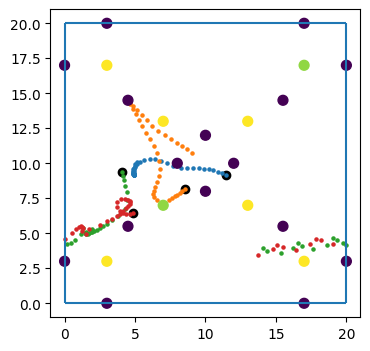

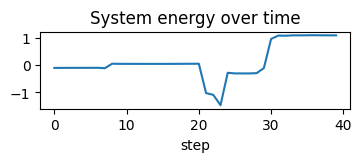

In [6]:
x = trajectory[...,0]
y = trajectory[...,1]

x_fw = framework[...,0]
y_fw = framework[...,1]
q_fw = framework[...,2]

plt.figure(figsize=(4,4))
plt.vlines([0,20],0,20)
plt.hlines([0,20],0,20)

plt.scatter(x[0], y[0], c='black')

for i in range(x.shape[1]):
    plt.scatter(x[:,i], y[:,i], s=5)

plt.scatter(x_fw, y_fw, c=q_fw, cmap='viridis', s=50)
# to also visualize the framework points along the boundaries
plt.scatter(x_fw+20, y_fw, c=q_fw, cmap='viridis', s=50)
plt.scatter(x_fw, y_fw+20, c=q_fw, cmap='viridis', s=50)
plt.scatter(x_fw+20, y_fw+20, c=q_fw, cmap='viridis', s=50)

plt.xlim(-1,21)
plt.ylim(-1,21)

plt.show()
plt.figure(figsize=(4,1))
plt.plot(energy)
plt.xlabel('step')
plt.title('System energy over time')
plt.show();

Implement task 3 below. Feel free to add extra code cells for different components of your implementation.